Interesting questions for data exploration:
* is site_id significant? Should we train different models for different sites (people in japan have different search / booking habits compared to the UK for instance).
* same question for visitor_location_country_id
* visitor_hist_starrating and visitor_hist_adr_usd are expected to be predictive, how many values are missing?
* Higher booking prob when price_usd is significantly lower than prop_log_historical_price, conditioned on the property_id
* Higher booking prob when in promotion
* random_bool - how often are random display sorts presented?
* Exploring booking behaviour, when is it more or less likely that a search will result in a booking (regardless of what hotels are shown), can this be predicted?
* Price and availability relative to competitor +1 good, (-1/0) bad, null. Does this booking probability all else being equal?

Sanity checks:
* srch_destination_id should be strongly correlated to the prop_country_id, prop_id
* booked prop_starrating correlated with visitor_hist_starrating
* price_usd correlated with visitor_hist_adr_usd

Aggregation ideas:
* comp_agg_rate_sum, comp_agg_rate_cnt (summing an counting)
* comp_agg_inv_sum, comp_agg_inv_cnt

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# set the number of diplayed columns in jupyter notebook to 100
pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('data/training_set_VU_DM.csv')

In [4]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [5]:
# how many flags are NA
sum(df.booking_bool.isna()), sum(df.click_bool.isna())

print("how many unique searches are there? ", df.srch_id.nunique())

print("how many unique properties are there? ", df.prop_id.nunique())

print("how many unique destinations are there? ", df.srch_destination_id.nunique())

how many unique searches are there?  199795
how many unique properties are there?  129113
how many unique destinations are there?  18127


In [6]:
print("the percentage of impressions resulting in a click", 100*sum(df.click_bool)/len(df.click_bool))
print("the percentage of impressions resulting in a booking", 100*sum(df.booking_bool)/len(df.booking_bool))

the percentage of impressions resulting in a click 4.474858254172207
the percentage of impressions resulting in a booking 2.7910511305481442


<Axes: >

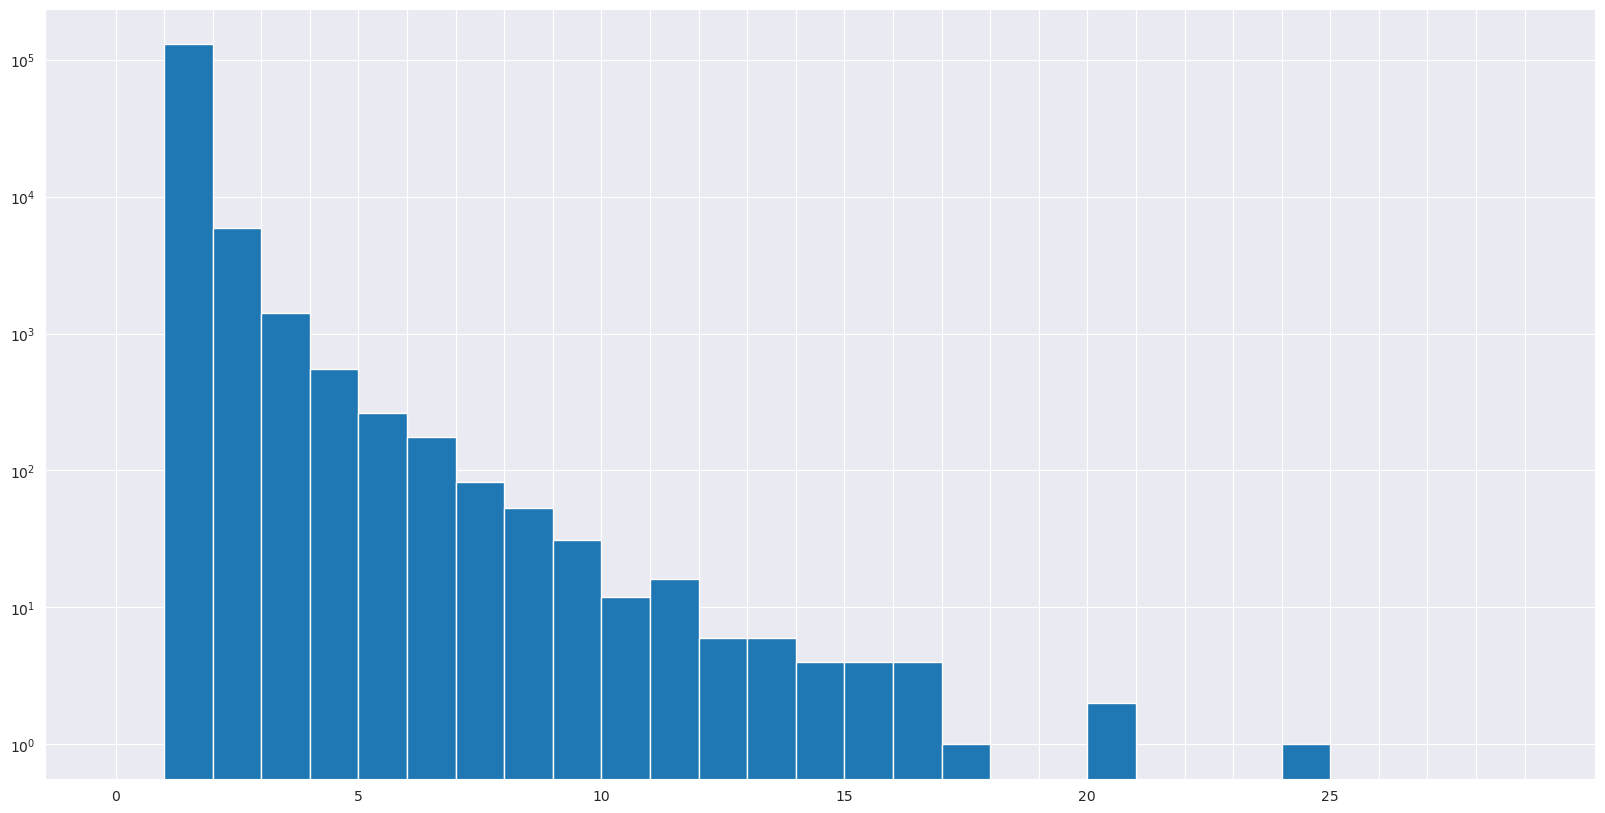

In [7]:
# Get a set of search ids which resulted in a booking
ids_with_booking = set(df[df.booking_bool == 1].srch_id)

fig, ax = plt.subplots(figsize=(20,10))
# the spacing between x ticks should be 1
ax.set_xticks(range(30))
# the spacing between x tick labels should be 5
xticks = np.array([None for _ in range(30)])
for i in range(30//5):
    xticks[5*i]=5*i
ax.set_xticklabels(xticks)
# set the axis to logarithmic
ax.set_yscale('log')

# Histogram of number of clicks for every search id with booking, the histogram bar width should be 1
# The histogram is plotted on an axis where the x tick distance is 1 and the tick label is shown every 5th tick
df[df.srch_id.isin(ids_with_booking)].groupby('srch_id').click_bool.sum().hist(bins=range(30), log=True)

In [8]:
# sanity check: assert that there are no search ids with a booking but no click
assert len(set(df[df.booking_bool == 1].srch_id) - set(df[df.click_bool == 1].srch_id)) == 0

## number of properties per search

<Axes: ylabel='Count'>

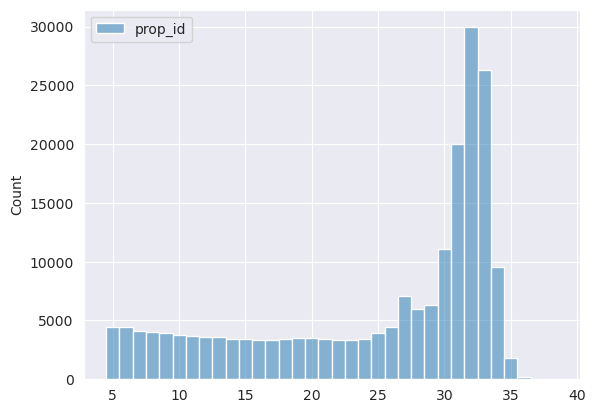

In [9]:
plt.figure()
sns.histplot(df.groupby('srch_id').agg({'prop_id':'nunique'}), discrete=True)

<Axes: xlabel='prop_id', ylabel='Density'>

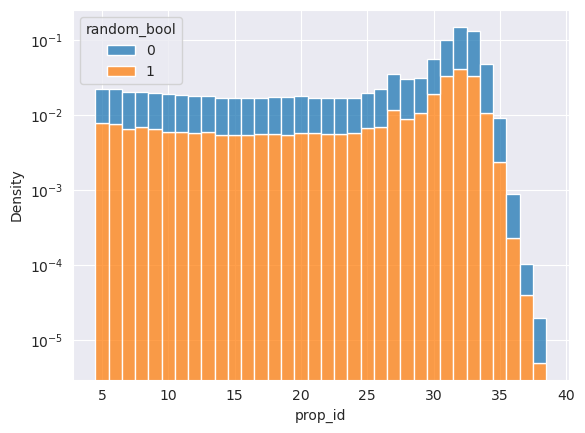

In [10]:
plt.figure()
sns.histplot(df.groupby(['random_bool', 'srch_id']).agg({'prop_id':'nunique'}),
             x='prop_id', multiple='stack', hue='random_bool', discrete=True, log_scale=(False, True), stat='density')

## random_bool

### how often are random display sorts presented?

In [11]:
# Is there any search id where all the displayed properties have the random_bool set to true?
# df.groupby('srch_id').agg({'random_bool':"sum", 'site_id':"count"})
np.any(df.groupby('srch_id').random_bool.nunique() > 1)
# Observation: random_bool applies to an entire search not just individual properties (either all properties are shown or none)

False

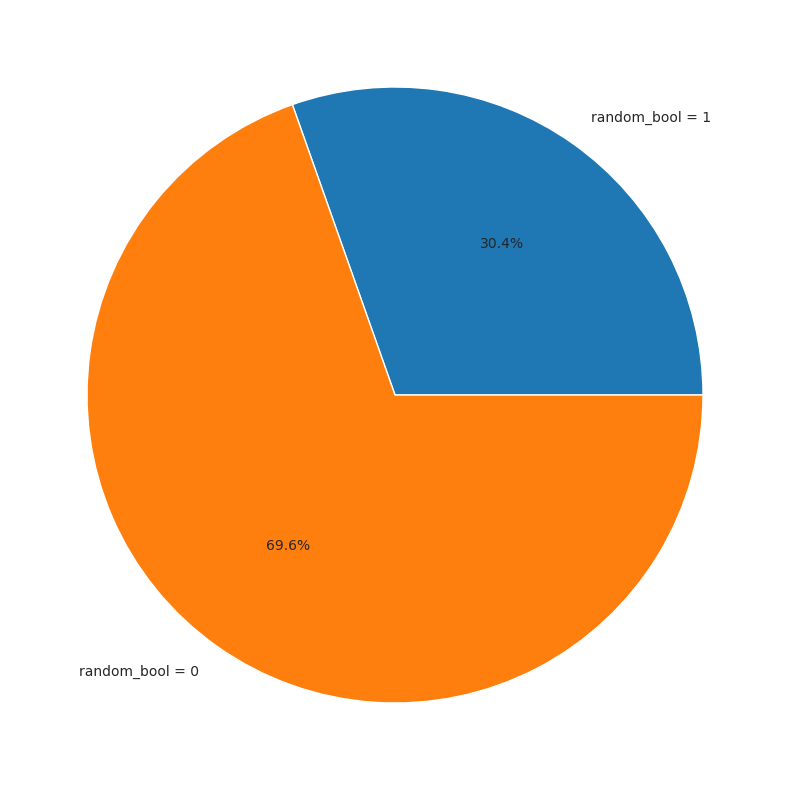

In [12]:
# pie chart of how many searches have random_bool set to true and how many to false
fig, ax = plt.subplots(figsize=(20,10))
ax.pie([len(set(df[df.random_bool == 1].srch_id)),
        len(set(df[df.random_bool == 0].srch_id))], labels=['random_bool = 1', 'random_bool = 0'], autopct='%1.1f%%');

### how many searches result in bookings and clicks for the two different values

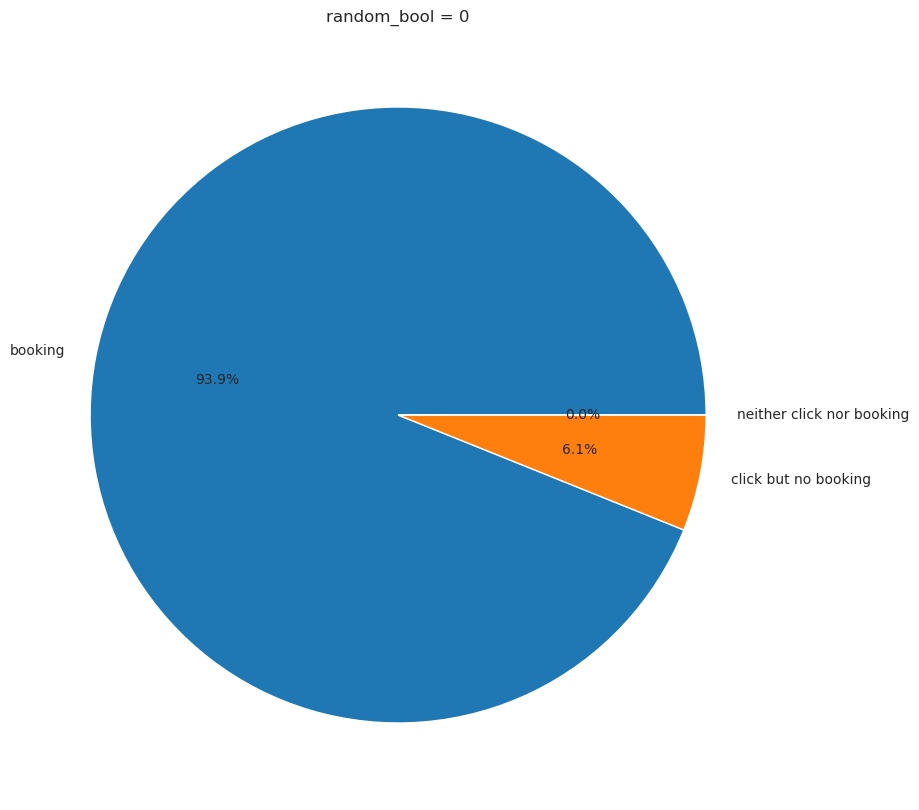

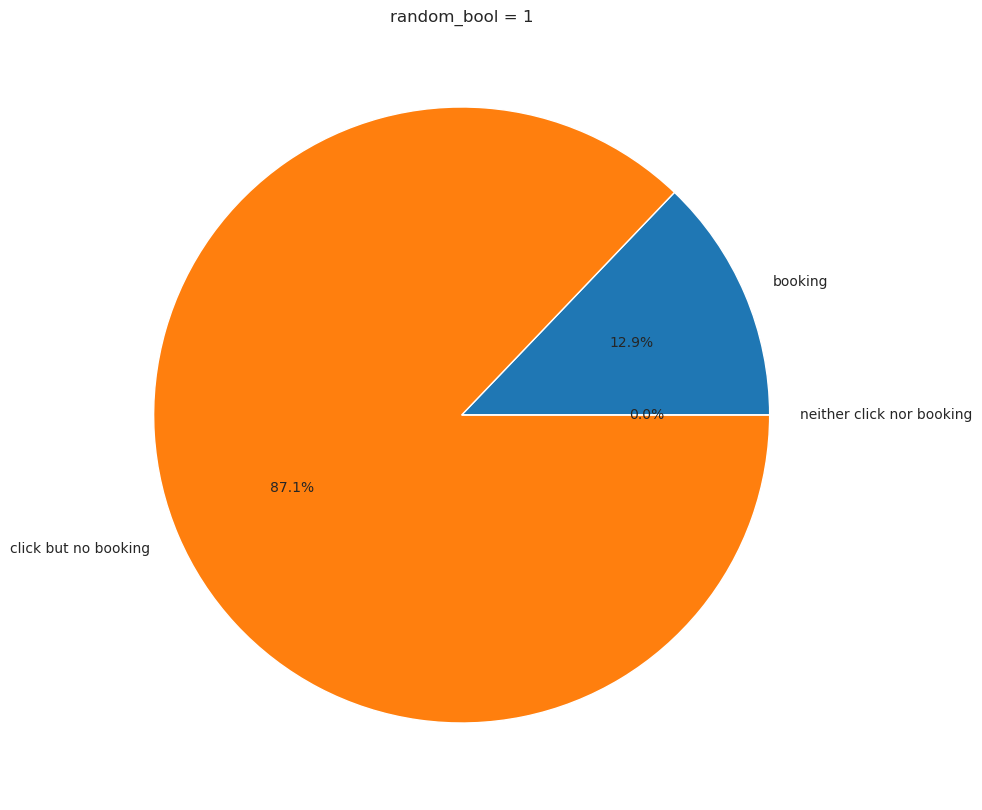

In [13]:
def pie_chart_random_bool(tg_val):
    id_subset = set(df[df.random_bool == tg_val].srch_id)
    df_filt = df[df.srch_id.isin(id_subset)]
    ids_with_booking = set(df_filt[df_filt.booking_bool == 1].srch_id)

    # pie chart with meaningful labels and legend of how many searches have a booking, a click but no booking, neither click nor booking
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(f'random_bool = {tg_val}')
    ax.pie([len(ids_with_booking),
            len(set(df_filt[df_filt.click_bool == 1].srch_id) - ids_with_booking),
            len(set(df_filt.srch_id) - set(df_filt[df_filt.click_bool == 1].srch_id))], labels=['booking', 'click but no booking', 'neither click nor booking'], autopct='%1.1f%%');

pie_chart_random_bool(0)
pie_chart_random_bool(1)

In [14]:
df_new = df.groupby('random_bool').agg({'booking_bool':['sum', 'count'], 'click_bool':'sum'})
# flatten the column names
df_new.columns = ['_'.join(col) for col in df_new.columns]

df_new['booking_prop'] = df_new['booking_bool_sum'] / df_new['booking_bool_count']
df_new['click_prop'] = df_new['click_bool_sum'] / df_new['booking_bool_count']
df_new


,booking_bool_sum,booking_bool_count,click_bool_sum,booking_prop,click_prop
random_bool,,,,,
0,130578,3491170,153502,0.037402,0.043969
1,7812,1467177,68377,0.005325,0.046604


### Conclusion

there is a significant difference in the booking and click statistics between the random and non-random display order

## P(position | booking)

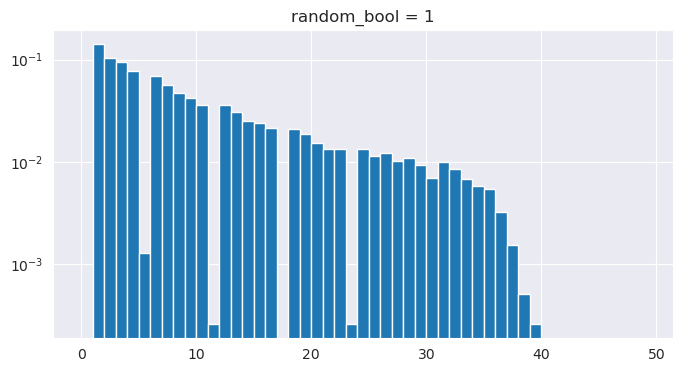

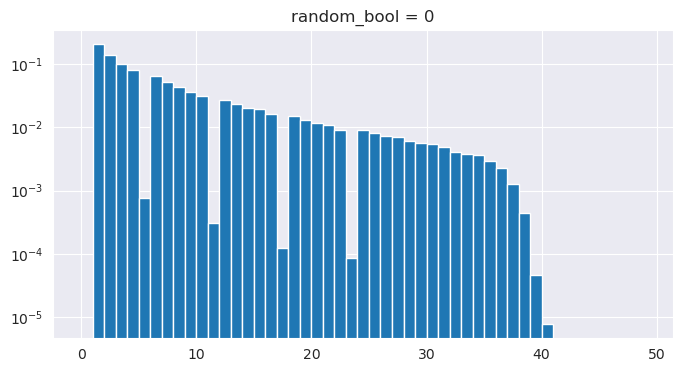

In [15]:
# Histogram of positions that where booked
def booking_pos_hist(random_bool):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_title(f'random_bool = {random_bool}')
    ax.set_yscale('log')
    id_subset = set(df[df.random_bool == random_bool].srch_id)
    df_filt = df[df.srch_id.isin(id_subset)]
    df_filt.query("booking_bool==1").position.hist(bins=range(50), ax=ax, density=True)

booking_pos_hist(random_bool=1)
booking_pos_hist(random_bool=0)

## P(position | click)

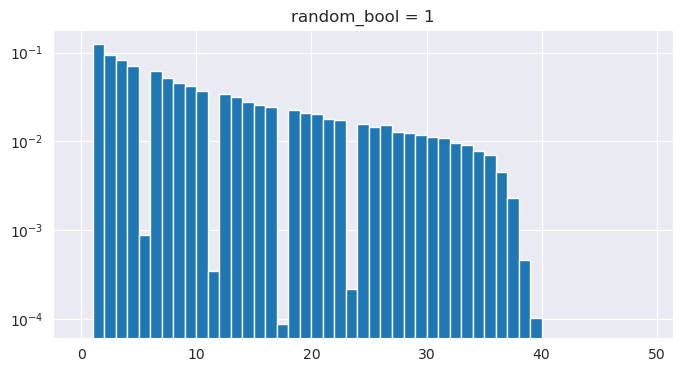

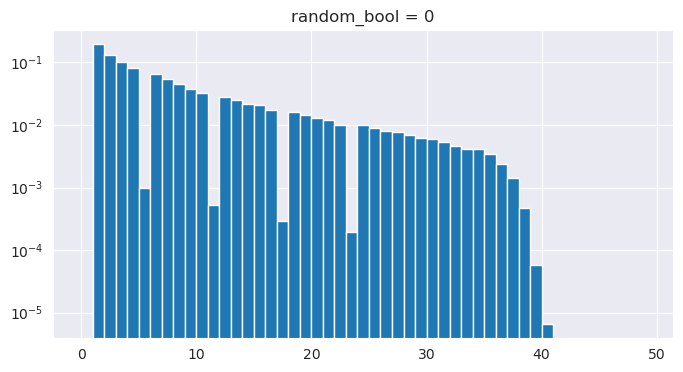

In [16]:
def click_pos_hist(random_bool):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_title(f'random_bool = {random_bool}')
    ax.set_yscale('log')
    id_subset = set(df[df.random_bool == random_bool].srch_id)
    df_filt = df[df.srch_id.isin(id_subset)]
    df_filt.query("click_bool==1").position.hist(bins=range(50), ax=ax, density=True)

click_pos_hist(random_bool=1)
click_pos_hist(random_bool=0)

What is going on with position 5, 11, 17, 23?

## P(booking | position)

In [17]:
# What is P(booking | position)
df_tmp = df.groupby(['position', 'random_bool']).agg({'booking_bool':['sum', 'count'], 'click_bool':['sum', 'count']})
# sanity check
assert np.all(df_tmp['booking_bool']['count'] == df_tmp['click_bool']['count']), "the number of action must be the same (no NAs in either click_bool or booking_bool)"

# normalize
df_tmp['booking_bool_prop'] = df_tmp['booking_bool']['sum'] / df_tmp['booking_bool']['count']
df_tmp['click_bool_prop'] = df_tmp['click_bool']['sum'] / df_tmp['click_bool']['count']

df_tmp['booking_bool_norm'] = 0
df_tmp['click_bool_norm'] = 0
df_tmp

booking_bool         click_bool           
                              sum   count        sum   count   
position random_bool                                           
1        0                  27014  138977      29908  138977  \
         1                   1101   60438       8481   60438   
2        0                  17976  138974      20271  138974   
         1                    817   60376       6487   60376   
3        0                  13385  138949      15381  138949   
...                           ...     ...        ...     ...   
38       1                      4    2426         32    2426   
39       0                      6    1184          9    1184   
         1                      2     393          7     393   
40       0                      1      50          1      50   
         1                      0      16          0      16   

                     booking_bool_prop click_bool_prop booking_bool_norm   
                                                                           
position random_bool                                                       
1        0                    0.194377        0.215201                 0  \
         1                    0.018217        0.140326                 0   
2        0                    0.129348        0.145862                 0   
         1                    0.013532        0.107443                 0   
3        0                    0.096330        0.110695                 0   
...                                ...             ...               ...   
38       1                    0.001649        0.013190                 0   
39       0                    0.005068        0.007601                 0   
         1                    0.005089        0.017812                 0   
40       0                    0.020000        0.020000                 0   
         1                    0.000000        0.000000                 0   

                     click_bool_norm  
                                      
position random_bool                  
1        0                         0  
         1                         0  
2        0                         0  
         1                         0  
3        0                         0  
...                              ...  
38       1                         0  
39       0                         0  
         1                         0  
40       0                         0  
         1                         0  

[80 rows x 8 columns]

In [18]:
# using the index, select all entries of df_tmp where random_bool is 0
df_tmp.loc[(slice(None), 0), 'booking_bool_norm'] = df_tmp.loc[(slice(None), 0), 'booking_bool_prop'] / df_tmp.loc[(slice(None), 0), 'booking_bool_prop'].sum()
df_tmp.loc[(slice(None), 0), 'click_bool_norm'] = df_tmp.loc[(slice(None), 0), 'click_bool_prop'] / df_tmp.loc[(slice(None), 0), 'click_bool_prop'].sum()
df_tmp.loc[(slice(None), 1), 'booking_bool_norm'] = df_tmp.loc[(slice(None), 1), 'booking_bool_prop'] / df_tmp.loc[(slice(None), 1), 'booking_bool_prop'].sum()
df_tmp.loc[(slice(None), 1), 'click_bool_norm'] = df_tmp.loc[(slice(None), 1), 'click_bool_prop'] / df_tmp.loc[(slice(None), 1), 'click_bool_prop'].sum()
df_tmp

booking_bool         click_bool           
                              sum   count        sum   count   
position random_bool                                           
1        0                  27014  138977      29908  138977  \
         1                   1101   60438       8481   60438   
2        0                  17976  138974      20271  138974   
         1                    817   60376       6487   60376   
3        0                  13385  138949      15381  138949   
...                           ...     ...        ...     ...   
38       1                      4    2426         32    2426   
39       0                      6    1184          9    1184   
         1                      2     393          7     393   
40       0                      1      50          1      50   
         1                      0      16          0      16   

                     booking_bool_prop click_bool_prop booking_bool_norm   
                                                                           
position random_bool                                                       
1        0                    0.194377        0.215201          0.179826  \
         1                    0.018217        0.140326          0.107165   
2        0                    0.129348        0.145862          0.119665   
         1                    0.013532        0.107443          0.079603   
3        0                    0.096330        0.110695          0.089119   
...                                ...             ...               ...   
38       1                    0.001649        0.013190          0.009699   
39       0                    0.005068        0.007601          0.004688   
         1                    0.005089        0.017812          0.029937   
40       0                    0.020000        0.020000          0.018503   
         1                    0.000000        0.000000          0.000000   

                     click_bool_norm  
                                      
position random_bool                  
1        0                  0.167014  
         1                  0.094618  
2        0                  0.113201  
         1                  0.072447  
3        0                  0.085909  
...                              ...  
38       1                  0.008894  
39       0                  0.005899  
         1                  0.012010  
40       0                  0.015522  
         1                  0.000000  

[80 rows x 8 columns]

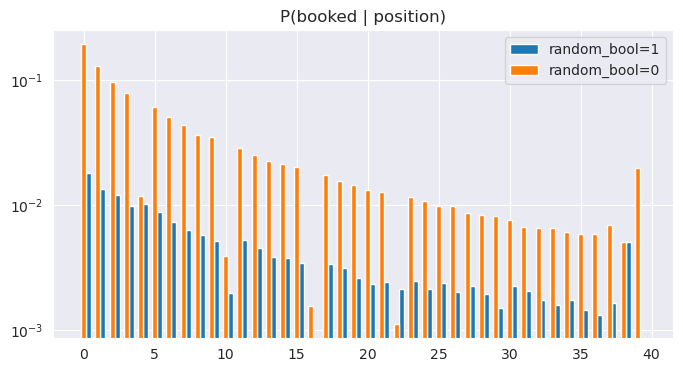

In [19]:
# create a stacked (side-by-side) bar plot for df_tmp  booking_bool_norm and click_bool_norm
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title(f'P(booked | position)')
ax.set_yscale('log')
width=0.35
#x = df_filt.reset_index().position
x = np.arange(40)
ax.bar(x+width, df_tmp.loc[(slice(None), 1), :]['booking_bool_prop'], label='random_bool=1', width=width)
ax.bar(x, df_tmp.loc[(slice(None), 0), :]['booking_bool_prop'], label='random_bool=0', width=width)
ax.legend()


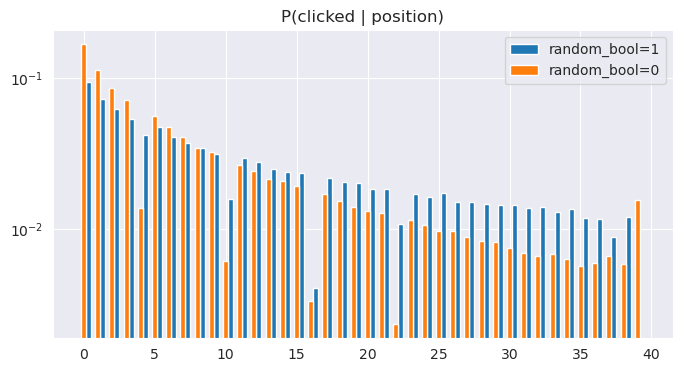

In [20]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title(f'P(clicked | position)')
ax.set_yscale('log')
width=0.35
#x = df_filt.reset_index().position
x = np.arange(40)
ax.bar(x+width, df_tmp.loc[(slice(None), 1), :]['click_bool_norm'], label='random_bool=1', width=width)
ax.bar(x, df_tmp.loc[(slice(None), 0), :]['click_bool_norm'], label='random_bool=0', width=width)
ax.legend()


## Revisiting P(position | booking)

<Axes: xlabel='position', ylabel='Probability'>

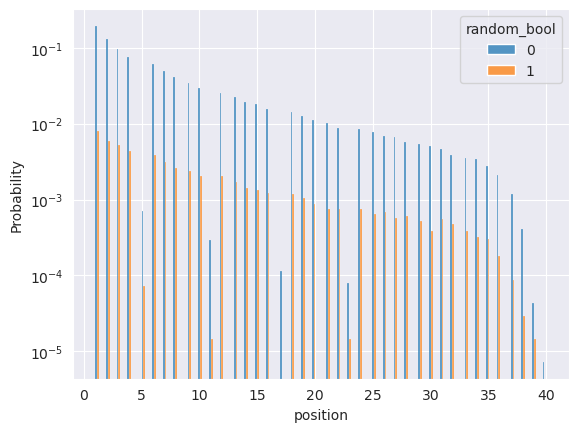

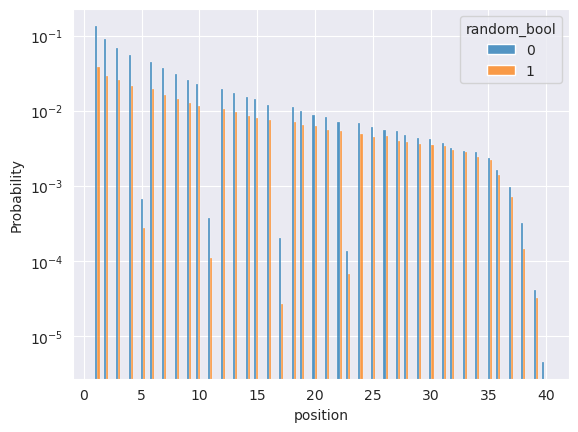

In [21]:
import seaborn as sns
plt.figure()
sns.histplot(df.query('booking_bool==1'), hue='random_bool', x='position', multiple='dodge', stat='probability', log_scale=(False, True))

plt.figure()
sns.histplot(df.query('click_bool==1'), hue='random_bool', x='position', multiple='dodge', stat='probability', log_scale=(False, True))


## competitor information

In [22]:
# add flag to indicate if any competitor has availability at a better rate
for i in range(1, 9):
    df[f'comp{i}_known'] = ~(df[f'comp{i}_rate'].isna() | df[f'comp{i}_inv'].isna() | (df[f'comp{i}_rate_percent_diff']>99))
    df[f'comp{i}_better'] = df[f'comp{i}_known'] & (df[f'comp{i}_rate']==-1) & (df[f'comp{i}_inv']<=0)

#df['comp_any_better'] = df['comp1_better'] | df['comp2_better'] | df['comp3_better'] | df['comp4_better'] | df['comp5_better'] | df['comp6_better'] | df['comp7_better'] | df['comp8_better']
df['comp_better_cnt'] = df['comp1_better'].astype(int) + df['comp2_better'].astype(int) + df['comp3_better'].astype(int) \
                        + df['comp4_better'].astype(int) + df['comp5_better'].astype(int) + df['comp6_better'].astype(int) \
                        + df['comp7_better'].astype(int) + df['comp8_better']

df['comp_known_cnt'] = df['comp1_known'].astype(int) + df['comp2_known'].astype(int) + df['comp3_known'].astype(int) \
                        + df['comp4_known'].astype(int) + df['comp5_known'].astype(int) + df['comp6_known'].astype(int) \
                        + df['comp7_known'].astype(int) + df['comp8_known']

In [23]:
display(df.groupby('comp_better_cnt').booking_bool.sum() / df.groupby('comp_better_cnt').booking_bool.count())
display(df.groupby('comp_better_cnt').booking_bool.count())

comp_better_cnt
0    0.028348
1    0.025724
2    0.023242
3    0.024130
4    0.021481
5    0.020300
6    0.043243
Name: booking_bool, dtype: float64

comp_better_cnt
0    4375593
1     314179
2     175459
3      70989
4      20809
5       1133
6        185
Name: booking_bool, dtype: int64

In [24]:
display(df.groupby('comp_known_cnt').booking_bool.sum() / df.groupby('comp_known_cnt').booking_bool.count())
display(df.groupby('comp_known_cnt').booking_bool.sum())


comp_known_cnt
0    0.025639
1    0.028652
2    0.029185
3    0.029777
4    0.028740
5    0.025884
6    0.024979
7    0.047619
Name: booking_bool, dtype: float64

comp_known_cnt
0    44113
1    16374
2    23374
3    31307
4    21739
5     1218
6      264
7        1
Name: booking_bool, dtype: int64

In [25]:
display(df.groupby('comp_known_cnt').click_bool.sum() / df.groupby('comp_known_cnt').click_bool.count())
display(df.groupby('comp_known_cnt').click_bool.sum())


comp_known_cnt
0    0.045789
1    0.044344
2    0.044482
3    0.044504
4    0.043554
5    0.041397
6    0.042104
7    0.047619
Name: click_bool, dtype: float64

comp_known_cnt
0    78781
1    25342
2    35626
3    46791
4    32945
5     1948
6      445
7        1
Name: click_bool, dtype: int64

### Conclusion
the number of competitors with a better price, decreases the booking and click probability=

<Axes: xlabel='comp_better_cnt', ylabel='comp_known_cnt'>

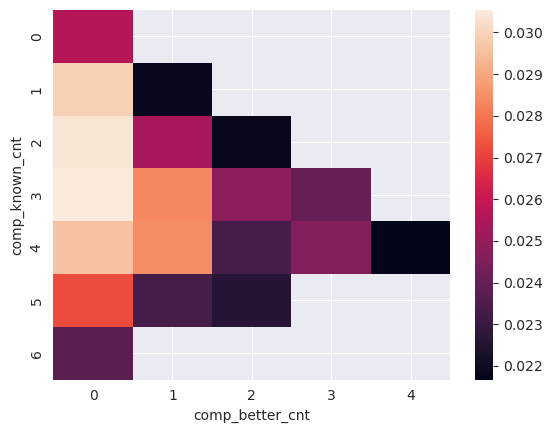

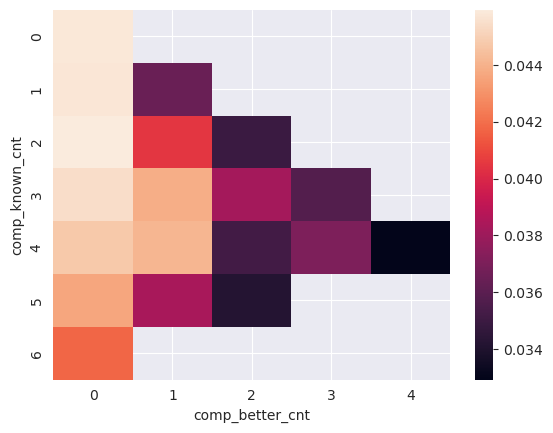

In [26]:
df_tmp = df.groupby(['comp_known_cnt', 'comp_better_cnt']).agg({'booking_bool' : ['sum', 'count'], 'click_bool' : ['sum', 'count']})

# flatten the columns
df_tmp['booking_prop'] = df_tmp['booking_bool']['sum'] / df_tmp['booking_bool']['count']
df_tmp['click_prop'] = df_tmp['click_bool']['sum'] / df_tmp['click_bool']['count']

# delete rows where booking_bool count is less than 2000
df_tmp_filt = df_tmp[df_tmp['booking_bool']['count'] > 2000]

plt.figure()
sns.heatmap(df_tmp_filt.reset_index().pivot(index='comp_known_cnt', columns='comp_better_cnt', values='booking_prop'))

plt.figure()
sns.heatmap(df_tmp_filt.reset_index().pivot(index='comp_known_cnt', columns='comp_better_cnt', values='click_prop'))

In [27]:
# How many impressions have at least one known competitor
sum(df['comp_known_cnt'] > 0), sum(df['comp_known_cnt'] == 0)

(3237829, 1720518)

### Conclusion

we can see that the probability of booking decreases either when comp_better_cnt increases for the same number of known competitors (horizontal from left to right), or when number of known competitors increases and comp_better_cnt increases (on the diagonal from top left to bottom right). Because the number of impressions where at least one is known is actually higher than when nothing is known, we can say that this feature is significant

In [28]:
# add effective rate percent diff
for i in range(1, 9):
    df[f'comp{i}_discount'] = (df[f'comp{i}_known']).astype(int) * (df[f'comp{i}_inv']<=0).astype(int) * (df[f'comp{i}_rate']!=0).astype(int) * -1 * df[f'comp{i}_rate'] * df[f'comp{i}_rate_percent_diff']


In [29]:
# add best competitor discount
df['comp_best_discount'] = df[[f'comp{i}_discount' for i in range(1, 9)]].max(axis=1)
df

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,comp1_known,comp1_better,comp2_known,comp2_better,comp3_known,comp3_better,comp4_known,comp4_better,comp5_known,comp5_better,comp6_known,comp6_better,comp7_known,comp7_better,comp8_known,comp8_better,comp_better_cnt,comp_known_cnt,comp1_discount,comp2_discount,comp3_discount,comp4_discount,comp5_discount,comp6_discount,comp7_discount,comp8_discount,comp_best_discount
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0,False,False,True,True,True,True,False,False,True,False,False,False,False,False,True,True,3,4,NaN,5.0,5.0,NaN,NaN,NaN,NaN,5.0,5.0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958342,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,77700,3,4.0,1,1.61,0.0471,0.00,2,118.00,0,16974,1,21,3,0,1,0,NaN,550.92,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4958343,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,88083,3,4.0,1,1.95,0.1520,0.00,3,89.00,0,16974,1,21,3,0,1,0,NaN,553.14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,False,False,False,False,False,False,False,False,False,False,False,False,Fal

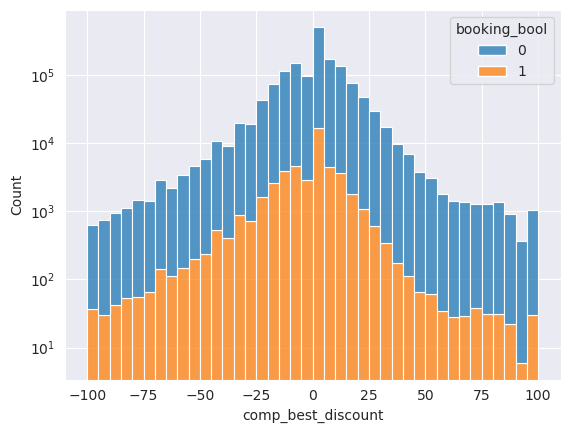

In [30]:
# plot booking count as a function of comp_best_discount when at least one competitor is known
sns.histplot(df.query('comp_known_cnt > 0'), x='comp_best_discount', hue='booking_bool', multiple='stack', log_scale=(False, True), binwidth=5, binrange=(-100, 100))
plt.savefig('test.png')

In [32]:
def get_booking_prop(df_tmp, col):
    df_new = df_tmp.groupby(col).agg({'booking_bool' : ['sum', 'count']})
    df_new['book_prop'] = df_new['booking_bool']['sum'] / df_new['booking_bool']['count']
    return df_new

In [33]:
df['comp_best_discount_rounded'] = (df['comp_best_discount'] / 50).round(1)
get_booking_prop(df, ['random_bool', 'comp_best_discount_rounded'])

booking_bool       book_prop
                                                sum count          
random_bool comp_best_discount_rounded                             
0           -2.0                                 18   266  0.067669
            -1.9                                 29   429  0.067599
            -1.8                                 40   711  0.056259
            -1.7                                 40   679  0.058910
            -1.6                                 62  1073  0.057782
...                                             ...   ...       ...
1            1.6                                  3   380  0.007895
             1.7                                  3   354  0.008475
             1.8                                  0   185  0.000000
             1.9                                  1   116  0.008621
             2.0                                  1   200  0.005000

[82 rows x 3 columns]

### Conclusion

increasing best discount decreases the ratio of booking/no_booking, interestingly this trend also happens when best_discount goes negative (worse price than expedia), doesn't really make sense.

In [34]:
comps = [f'comp{i}_' for i in range(1, 9)]
df_filt = df.drop(columns=[c for c in df.columns if c[:6] in comps])

# Dealing with NAs

In [35]:
# let's write a function to preprocess the competitor info
def restructure_comp_info(_df):
    for i in range(1, 9):
        _df[f'comp{i}_known'] = ~(_df[f'comp{i}_rate'].isna() | _df[f'comp{i}_inv'].isna() | (_df[f'comp{i}_rate_percent_diff']>99))
        _df[f'comp{i}_better'] = _df[f'comp{i}_known'] & (_df[f'comp{i}_rate']==-1) & (_df[f'comp{i}_inv']<=0)

    _df['comp_better_cnt'] = _df['comp1_better'].astype(int) + _df['comp2_better'].astype(int) + _df['comp3_better'].astype(int) \
                            + _df['comp4_better'].astype(int) + _df['comp5_better'].astype(int) + _df['comp6_better'].astype(int) \
                            + _df['comp7_better'].astype(int) + _df['comp8_better']

    _df['comp_known_cnt'] = _df['comp1_known'].astype(int) + _df['comp2_known'].astype(int) + _df['comp3_known'].astype(int) \
                            + _df['comp4_known'].astype(int) + _df['comp5_known'].astype(int) + _df['comp6_known'].astype(int) \
                            + _df['comp7_known'].astype(int) + _df['comp8_known']   
    
    for i in range(1, 9):
        _df[f'comp{i}_discount'] = (_df[f'comp{i}_known']).astype(int) * (_df[f'comp{i}_inv']<=0).astype(int) * (_df[f'comp{i}_rate']!=0).astype(int) * -1 * _df[f'comp{i}_rate'] * _df[f'comp{i}_rate_percent_diff']

    _df['comp_best_discount'] = _df[[f'comp{i}_discount' for i in range(1, 9)]].max(axis=1)

    comps = [f'comp{i}_' for i in range(1, 9)]
    df_filt = df.drop(columns=[c for c in _df.columns if c[:6] in comps])

    return df_filt

In [36]:
df_filt['comp_best_discount'] = df_filt['comp_best_discount'].fillna(0)
df_filt

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,comp_better_cnt,comp_known_cnt,comp_best_discount,comp_best_discount_rounded
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,27,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,0,NaN,0,0,4,0.0,NaN
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,26,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,0,NaN,0,0,3,0.0,NaN
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,21,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,0,NaN,0,0,4,0.0,NaN
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,34,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,0,NaN,0,3,4,5.0,0.1
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,4,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,0,NaN,0,0,4,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958342,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,77700,3,4.0,1,1.61,0.0471,0.00,2,118.00,0,16974,1,21,3,0,1,0,NaN,550.92,0,0,NaN,0,0,0,0.0,NaN
4958343,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,88083,3,4.0,1,1.95,0.1520,0.00,3,89.00,0,16974,1,21,3,0,1,0,NaN,553.14,0,0,NaN,0,0,0,0.0,NaN
4958344,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,94508,3,3.5,1,1.10,0.0164,0.00,4,99.00,0,16974,1,21,3,0,1,0,NaN,544.43,0,0,NaN,0,0,0,0.0,NaN
4958345,332785,2013-06-30 19:55:18,5,219,NaN,NaN,219,128360,3,5.0,1,1.95,0.0662,0.00,1,139.00,0,16974,1,21,3,0,1,0,NaN,550.38,0,1,157.84,1,0,0,0.0,NaN


In [37]:
# Checking each columns which contains any NAs
cols_with_nas = [c for c in df_filt.columns if df_filt[c].isna().any()]
cols_with_nas
    

['visitor_hist_starrating',
 'visitor_hist_adr_usd',
 'prop_review_score',
 'prop_location_score2',
 'srch_query_affinity_score',
 'orig_destination_distance',
 'gross_bookings_usd',
 'comp_best_discount_rounded']

In [38]:
df_test = pd.read_csv('data/test_set_VU_DM.csv')
df_test_file = restructure_comp_info(df_test)
cols_with_nas_test = [c for c in df_filt.columns if df_filt[c].isna().any()]


In [39]:
cols_with_nas_test

['visitor_hist_starrating',
 'visitor_hist_adr_usd',
 'prop_review_score',
 'prop_location_score2',
 'srch_query_affinity_score',
 'orig_destination_distance',
 'gross_bookings_usd',
 'comp_best_discount_rounded']

In [40]:
def print_missing(col):
    miss_cnt = df[col].isna().sum()
    total_cnt = len(df[col])
    perc_miss = 100 * miss_cnt / total_cnt
    print(f'{col} missing count {miss_cnt} out of {total_cnt} => {round(perc_miss)}% missing')

for col in cols_with_nas:
    print_missing(col)

# visitor_hist_adr_usd

visitor_hist_starrating missing count 4706481 out of 4958347 => 95% missing
visitor_hist_adr_usd missing count 4705359 out of 4958347 => 95% missing
prop_review_score missing count 7364 out of 4958347 => 0% missing
prop_location_score2 missing count 1090348 out of 4958347 => 22% missing
srch_query_affinity_score missing count 4640941 out of 4958347 => 94% missing
orig_destination_distance missing count 1607782 out of 4958347 => 32% missing
gross_bookings_usd missing count 4819957 out of 4958347 => 97% missing
comp_best_discount_rounded missing count 3377857 out of 4958347 => 68% missing


In [41]:
# TODO: we don't care about gross_bookings_usd, remove it
# srch_query_affinity_score, visitor_hist_adr_usd, visitor_hist_starrating could be added at the end by a boosting model

<Axes: xlabel='prop_location_score2', ylabel='Count'>

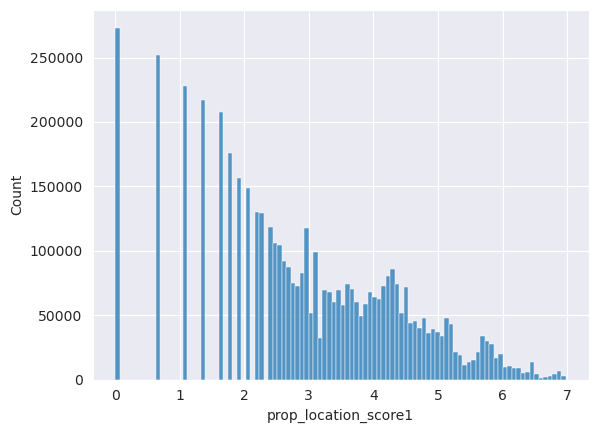

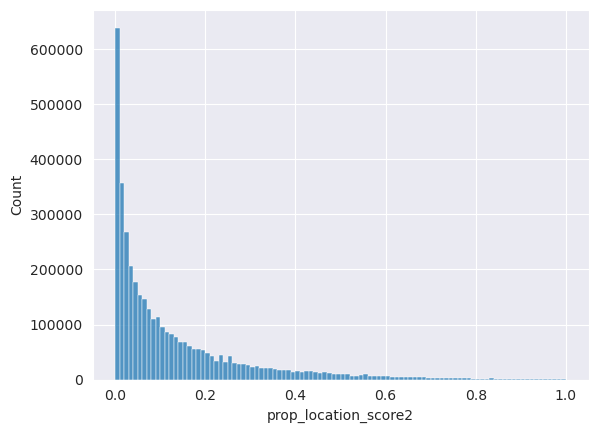

In [42]:
# let's see how many impressions have prop_location_score1 unknown but prop_location_score2 known
p1_known = ~df.prop_location_score1.isna()
p2_known = ~df.prop_location_score2.isna()

plt.figure()
sns.histplot(df.prop_location_score1, bins=100)
plt.figure()
sns.histplot(df.prop_location_score2, bins=100)

## prop_review_score

In [43]:
# let's look at prop_review_score, since so few are missing, imputing might make sense
# since a property score is unknown, we can initialize it with the location mean, even better with the mean of other properties of the same star rating in that location
no_score = df[df.prop_review_score.isna()].prop_id.unique()
yes_score = df[~df.prop_review_score.isna()].prop_id.unique()

In [44]:
set(yes_score).intersection(set(no_score))

set()

In [45]:
df_tmp = df_filt.copy()
df_tmp['no_score'] = df_tmp.prop_review_score.isna()

Observation: prop_review_score missing, even though not many are missing, leads to a significantly lower booking proportion

<Axes: xlabel='prop_review_score', ylabel='Count'>

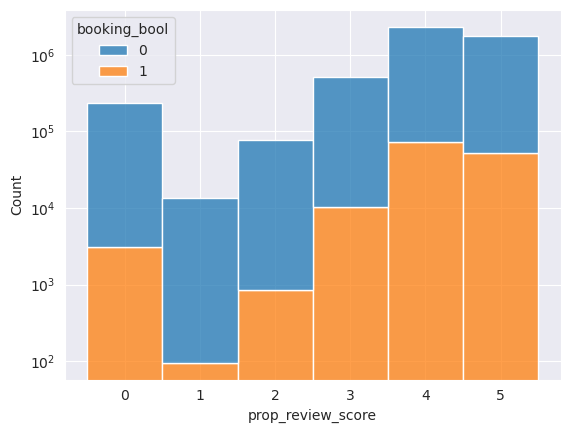

In [46]:
sns.histplot(df_tmp, x='prop_review_score', hue='booking_bool', discrete=True, multiple='stack', log_scale=(False, True))

In [47]:
score_is_zero = (df_tmp.prop_review_score<0.1)
df_tmp['score_is_zero'] = score_is_zero

get_booking_prop(df_tmp, 'score_is_zero')

booking_bool          book_prop
                       sum    count          
score_is_zero                                
False               135257  4725053  0.028625
True                  3133   233294  0.013429

In [48]:
get_booking_prop(df_tmp, 'prop_review_score')

booking_bool          book_prop
                           sum    count          
prop_review_score                                
0.0                       3133   233294  0.013429
1.0                         95    13303  0.007141
1.5                        130    14465  0.008987
2.0                        709    62301  0.011380
2.5                       2309   143886  0.016047
3.0                       7924   375905  0.021080
3.5                      21910   768054  0.028527
4.0                      50312  1556948  0.032315
4.5                      46942  1546880  0.030346
5.0                       4810   235947  0.020386

In [49]:
get_booking_prop(df_tmp, 'no_score')

booking_bool          book_prop
                  sum    count          
no_score                                
False          138274  4950983  0.027929
True              116     7364  0.015752

In [50]:
# For simplicity, we set the missing score to 0, but we could create a separate category, or set it to -1
# TODO: fill prop_review_score NAs with 0

<Axes: xlabel='prop_location_score1', ylabel='Count'>

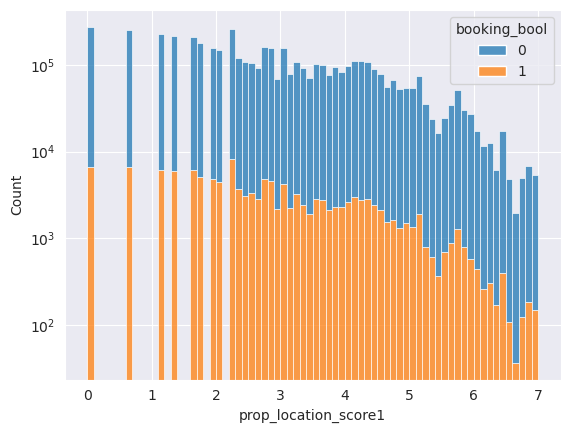

In [51]:
sns.histplot(df_tmp, x='prop_location_score1', hue='booking_bool', discrete=False, multiple='stack', log_scale=(False, True), binwidth=0.1)

## prop_location_score2

<Axes: xlabel='prop_location_score2', ylabel='Count'>

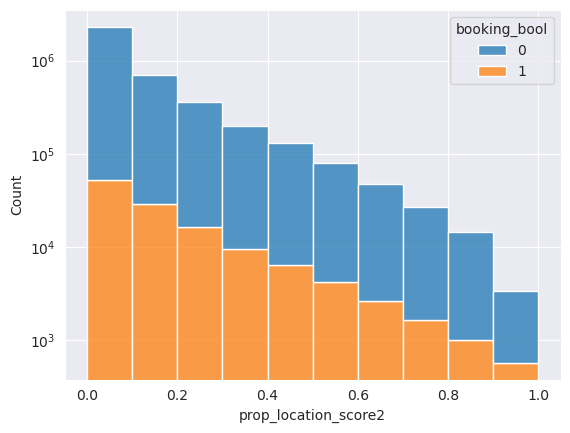

In [52]:
sns.histplot(df_tmp, x='prop_location_score2', hue='booking_bool', discrete=False, multiple='stack', log_scale=(False, True), binwidth=0.1)

In [53]:
df_tmp['prop_location_score2_rounded'] = df_tmp['prop_location_score2'].round(2)
get_booking_prop(df_tmp, 'prop_location_score2_rounded')

booking_bool         book_prop
                                      sum   count          
prop_location_score2_rounded                               
0.00                                 4466  403716  0.011062
0.01                                 6874  427199  0.016091
0.02                                 6302  308587  0.020422
0.03                                 5572  236846  0.023526
0.04                                 5116  188187  0.027186
...                                   ...     ...       ...
0.96                                   43     257  0.167315
0.97                                   43     274  0.156934
0.98                                   63     267  0.235955
0.99                                   73     280  0.260714
1.00                                   53     203  0.261084

[101 rows x 3 columns]

In [54]:
df_tmp['prop_location_score2_missing'] = df_tmp['prop_location_score2'].isna()
get_booking_prop(df_tmp, 'prop_location_score2_missing')

booking_bool          book_prop
                                      sum    count          
prop_location_score2_missing                                
False                              123916  3867999  0.032036
True                                14474  1090348  0.013275

In [55]:
# prop_location_score2 seems to scale monotonically with the booking probability
# if location score2 is missing, then the booking probability is much lower

# So we either set the score to 0, or we set the score to 0 AND introduce a new flag prop_location_score2_missing
# TODO: add prop_location_score2_missing

## orig_destination_distance

<Axes: xlabel='orig_destination_distance', ylabel='Count'>

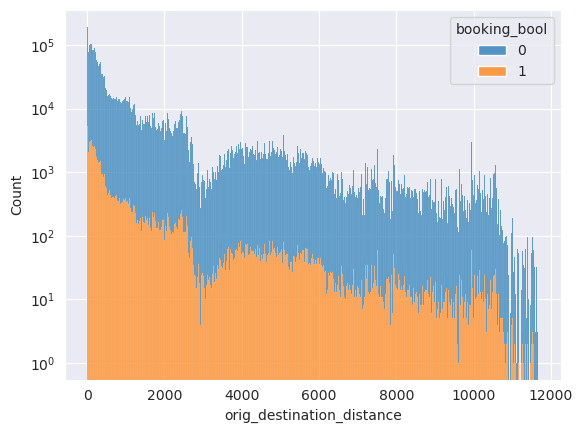

In [56]:
sns.histplot(df_tmp, x='orig_destination_distance', hue='booking_bool', discrete=False, multiple='stack', log_scale=(False, True))

In [57]:
# this doesn't seem to make sense as an unprocessed field
# we could infer the distances of the properties to the destination center using some trigonometry, but probably the star rating already includes this, so we can drop this field

# TODO: drop this field

# Dealing with IDs

In [58]:
def compare_train_test(col):
    prop_train = set(df[col].unique())
    prop_test = set(df_test[col].unique())

    # Get the properties in the train set but not in the test set or vice-versa?
    return len(prop_train), len(prop_test), len(prop_test.difference(prop_train)), len(prop_train.difference(prop_test))

compare_train_test('prop_id')

(129113, 129438, 7773, 7448)

In [59]:
compare_train_test('site_id')

# Is this redundant with visitor_location_country_id?

(34, 34, 0, 0)

In [60]:
compare_train_test('visitor_location_country_id')

(210, 210, 8, 8)

In [61]:
compare_train_test('srch_id') # NOTE!!! srch_id is not unique per train-test split!

(199795, 199549, 79635, 79881)

## srch_id

In [62]:
# are there duplicate sech_id, position pairs in the train set?
(df.groupby(['srch_id', 'position']).site_id.count() > 1).sum()
(df.groupby(['srch_id', 'prop_id']).site_id.count() > 1).sum()
(df_test.groupby(['srch_id', 'prop_id']).site_id.count() > 1).sum()

0

In [63]:
df.srch_id.unique()

array([     1,      4,      6, ..., 332782, 332784, 332785])

In [64]:
# Let's check if the sech_id is the same for the train-test split by grouping by all search criteria and comparing train to test
common_ids = set(df.srch_id.unique()).intersection(set(df_test.srch_id.unique()))
grp_train = df[df.srch_id.isin(common_ids)].groupby(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'prop_id']).site_id.count()

grp_test = df_test[df_test.srch_id.isin(common_ids)].groupby(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'prop_id']).site_id.count()
    #.agg({'prop_id':'count', 'visitor_hist_starrating':'nunique', 'visitor_hist_adr_usd':'nunique'})

In [65]:
assert (grp_train>1).sum() == 0, "a property can only appear once per search"
grp_train.sort_index(level=0)

srch_id  date_time            site_id  visitor_location_country_id  srch_destination_id  srch_length_of_stay  srch_booking_window  srch_adults_count  srch_children_count  srch_room_count  srch_saturday_night_bool  prop_id
1        2013-04-04 08:32:15  12       187                          23246                1                    0                    4                  0                    1                1                         893        1
                                                                                                                                                                                                                      10404      1
                                                                                                                                                                                                                      21315      1
                                                                                                 

In [66]:
assert (grp_test>1).sum() == 0, "a property can only appear once per search"
grp_test.sort_index(level=0)

srch_id  date_time            site_id  visitor_location_country_id  srch_destination_id  srch_length_of_stay  srch_booking_window  srch_adults_count  srch_children_count  srch_room_count  srch_saturday_night_bool  prop_id
1        2013-02-02 15:27:40  24       216                          19222                1                    10                   2                  0                    1                0                         3180       1
                                                                                                                                                                                                                      5543       1
                                                                                                                                                                                                                      14142      1
                                                                                                 

### Conclusion: srch_id can not correlated between train and test, overlap in values is coincidental

In [67]:
# by adding the max id from the train set to the test set srch_ids we get non-overlapping sets
df_test2 = df_test.copy()
df_test2['srch_id'] += df.srch_id.max()

assert len(set(df_test2.srch_id.unique()).intersection(set(df.srch_id.unique()))) == 0

## srch_destination_id and prop_country_id

In [68]:
# can the srch_destination_id be correlated between train and test?
df.groupby(['srch_destination_id', 'prop_country_id', 'prop_id']).site_id.count()

srch_destination_id  prop_country_id  prop_id
2                    181              985        1
                                      1974       1
                                      3003       1
                                      10729      2
                                      14413      1
                                                ..
28416                55               125619     2
                                      131144     1
                                      134423     2
                                      134593     1
                                      137494     2
Name: site_id, Length: 610375, dtype: int64

In [69]:
df_test.groupby(['srch_destination_id', 'prop_country_id', 'prop_id']).site_id.count()

srch_destination_id  prop_country_id  prop_id
2                    181              985        1
                                      1974       1
                                      3003       1
                                      14413      1
                                      41271      1
                                                ..
28416                55               125619     1
                                      131144     1
                                      134136     1
                                      134423     3
                                      137494     1
Name: site_id, Length: 612744, dtype: int64

In [70]:
# compare some statistics for srch_destination_id between train and test
cols = ['prop_starrating', 'prop_review_score', 'prop_location_score1', 'prop_location_score1', 'prop_id']
df.groupby(['srch_destination_id', 'prop_country_id'])[cols].agg({c : ['mean', 'median', 'std'] if c != 'prop_id' else 'count' for c in cols})

prop_starrating                    
                                               mean median       std   
srch_destination_id prop_country_id                                    
2                   181                    3.145833    3.0  1.202649  \
3                   53                     3.625000    4.0  0.744024   
5                   60                     2.750000    2.5  0.886405   
7                   220                    4.461538    5.0  0.660225   
8                   129                    4.000000    4.0  0.612372   
...                                             ...    ...       ...   
28407               219                    2.864151    3.0  0.872645   
28411               219                    2.434426    3.0  1.004023   
28412               158                    4.000000    4.0  1.000000   
28413               219                    2.307692    3.0  1.182132   
28416               55                     3.461538    3.0  0.663252   

                                    prop_review_score                    
                                                 mean median       std   
srch_destination_id prop_country_id                                      
2                   181                      3.000000   4.00  1.669501  \
3                   53                       2.062500   1.75  2.227066   
5                   60                       1.250000   0.00  1.732051   
7                   220                      3.230769   4.00  1.921538   
8                   129                      4.147059   4.00  0.385872   
...                                               ...    ...       ...   
28407               219                      3.882547   4.00  0.487451   
28411               219                      3.721311   4.00  1.287334   
28412               158                      1.900000   2.00  1.884144   
28413               219                      3.807692   4.00  0.990338   
28416               55                       3.215385   3.50  1.608010   

                                    prop_location_score1                    
                                                    mean median       std   
srch_destination_id prop_country_id                                         
2                   181                         2.229375   2.56  1.368396  \
3                   53                          0.735000   0.69  0.720773   
5                   60                          2.502500   2.94  0.780929   
7                   220                         1.366154   1.79  0.735227   
8                   129                         1.752353   1.61  0.722941   
...                                                  ...    ...       ...   
28407               219                         3.273632   3.30  0.322911   
28411               219                         0.853443   1.10  0.577055   
28412               158                         1.594000   2.40  1.166439   
28413               219                         1.491538   1.95  0.796648   
28416               55                          0.984308   0.69  1.008920   

                                    prop_id  
                                      count  
srch_destination_id prop_country_id          
2                   181                  48  
3                   53                    8  
5                   60                    8  
7                   220                  13  
8                   129                  17  
...                                     ...  
28407               219                1060  
28411               219                 122  
28412               158                   5  
28413               219                  13  
28416               55                   65  

[18237 rows x 10 columns]

In [71]:
df_test.groupby(['srch_destination_id', 'prop_country_id'])[cols].agg({c : ['mean', 'median', 'std'] if c != 'prop_id' else 'count' for c in cols})

prop_starrating                    
                                               mean median       std   
srch_destination_id prop_country_id                                    
2                   181                    3.517241    3.0  0.784706  \
5                   60                     2.857143    3.0  0.899735   
6                   219                    2.892857    3.0  0.867149   
10                  220                    4.384615    4.0  0.571099   
12                  219                    2.755102    3.0  0.671849   
...                                             ...    ...       ...   
28408               219                    2.642857    3.0  0.633324   
28411               219                    2.225225    3.0  1.180791   
28414               99                     2.096774    2.0  1.044185   
28415               55                     4.312500    4.0  0.592289   
28416               55                     3.500000    4.0  0.623610   

                                    prop_review_score                    
                                                 mean median       std   
srch_destination_id prop_country_id                                      
2                   181                      3.448276   4.00  1.513893  \
5                   60                       1.428571   0.00  1.789520   
6                   219                      3.581818   4.00  1.272078   
10                  220                      3.640000   4.00  1.194780   
12                  219                      3.505102   3.50  0.986468   
...                                               ...    ...       ...   
28408               219                      3.785714   4.25  0.934680   
28411               219                      3.527027   4.00  1.490634   
28414               99                       3.161290   3.50  0.977983   
28415               55                       4.312500   4.50  0.304536   
28416               55                       3.304348   3.75  1.540124   

                                    prop_location_score1                    
                                                    mean median       std   
srch_destination_id prop_country_id                                         
2                   181                         3.001034   3.53  0.971620  \
5                   60                          2.440000   2.94  0.821604   
6                   219                         1.882321   2.25  0.691094   
10                  220                         2.472692   2.89  0.842029   
12                  219                         1.600204   1.61  0.719623   
...                                                  ...    ...       ...   
28408               219                         0.750714   0.69  0.494811   
28411               219                         0.839189   1.10  0.577057   
28414               99                          4.990000   5.02  0.531996   
28415               55                          4.938750   5.05  0.387712   
28416               55                          1.135652   0.69  0.986323   

                                    prop_id  
                                      count  
srch_destination_id prop_country_id          
2                   181                  29  
5                   60                    7  
6                   219                  56  
10                  220                  26  
12                  219                 392  
...                                     ...  
28408               219                  14  
28411               219                 111  
28414               99                   31  
28415               55                   32  
28416               55                   46  

[18187 rows x 10 columns]

### Conclusion: srch_destination_id can be correlated between train and test (refers to the same destination)

In [72]:
compare_train_test('prop_country_id') # keep?

(172, 167, 0, 5)

In [73]:
# train - test matching / correspondence ?
common_prop_ids = set(df.prop_id.unique()).intersection(set(df_test.prop_id.unique()))

df[df.prop_id.isin(common_prop_ids)].groupby(['prop_id', 'prop_country_id', 'srch_destination_id']).site_id.count()

prop_id  prop_country_id  srch_destination_id
1        219              3931                    2
                          6475                   52
                          14215                   2
                          16037                   1
                          20983                   2
                                                 ..
140820   215              27458                   1
140821   31               6327                    1
                          10432                   1
                          13509                   4
                          18417                   1
Name: site_id, Length: 600336, dtype: int64

In [74]:
df_test[df_test.prop_id.isin(common_prop_ids)].groupby(['prop_id', 'prop_country_id', 'srch_destination_id']).site_id.count()

prop_id  prop_country_id  srch_destination_id
1        219              3931                    1
                          6475                   48
                          14215                   1
                          15587                   1
                          16037                   1
                                                 ..
140820   215              17074                   1
                          26585                  17
                          27972                   1
140821   31               23788                   1
                          27481                   1
Name: site_id, Length: 602358, dtype: int64

In [75]:
# looking at the data frames it seems they can be matched
# let's check some statistics as well

df_test[df_test.prop_id.isin(common_prop_ids)].groupby(['prop_id', 'prop_country_id'])[['price_usd', 'site_id']].agg({'price_usd' : ['mean', 'median', 'std', 'count']}).sort_values(by=[('price_usd', 'count')], ascending=False)

price_usd                          
                               mean  median         std count
prop_id prop_country_id                                      
104517  219              111.548350   96.00  124.879242  2376
124342  219              120.240191  104.88  128.379783  2352
68420   219               73.068017   53.00  339.388128  2295
134154  219               66.429315   47.00  400.352749  2293
59781   219              205.465104  184.00  187.610021  2269
...                             ...     ...         ...   ...
69344   50                73.580000   73.58         NaN     1
15598   109              282.780000  282.78         NaN     1
69366   117              139.000000  139.00         NaN     1
69367   219               56.000000   56.00         NaN     1
96539   99                75.340000   75.34         NaN     1

[121665 rows x 4 columns]

In [76]:
df[df.prop_id.isin(common_prop_ids)].groupby(['prop_id', 'prop_country_id'])[['price_usd', 'site_id']].agg({'price_usd' : ['mean', 'median', 'std', 'count']}).sort_values(by=[('price_usd', 'count')], ascending=False)

price_usd                          
                               mean  median         std count
prop_id prop_country_id                                      
104517  219              108.373649   93.98  124.446647  2357
124342  219              117.774450  102.00  137.651539  2355
68420   219               65.593383   50.90  138.200774  2285
40279   219              237.649407  211.90  295.046614  2275
134154  219               58.033655   45.00  137.619847  2257
...                             ...     ...         ...   ...
101492  117              173.000000  173.00         NaN     1
50851   4                 99.680000   99.68         NaN     1
37946   129              102.170000  102.17         NaN     1
101488  117               41.320000   41.32         NaN     1
129116  31               165.440000  165.44         NaN     1

[121665 rows x 4 columns]

### Conclusion: prop_id and prop_country_id can be matched between train and test (refers to the same property)

In [77]:
df.query('booking_bool==1').groupby(['prop_country_id', 'srch_destination_id']).booking_bool.count()

prop_country_id  srch_destination_id
1                15400                   2
                 15651                   5
2                2525                    2
                 4026                   74
                 7114                    1
                                        ..
230              15861                   2
                 20213                  15
                 21627                   5
                 25639                   5
                 26427                  18
Name: booking_bool, Length: 15100, dtype: int64

In [78]:
compare_train_test('srch_destination_id')

(18127, 18049, 5588, 5666)

In [79]:
# check per srch_id what is the number of prop_country_id
idx = (df.groupby('srch_id').prop_country_id.nunique()>1)
srch_ids_with_more_than1_ctry = df.groupby('srch_id').prop_country_id.nunique()[idx].index.unique()
df[df.srch_id.isin(srch_ids_with_more_than1_ctry)].groupby(['srch_id', 'prop_country_id']).booking_bool.sum()

srch_id  prop_country_id
75       100                0
         219                1
1026     100                1
         219                0
1326     39                 0
                           ..
329608   219                0
332069   39                 0
         202                0
332428   39                 1
         202                0
Name: booking_bool, Length: 2226, dtype: int64

In [80]:
# sanity check srch_destination_id strongly correlated with booked prop_country_id
df_new = df.query('booking_bool==1').groupby('srch_destination_id').prop_country_id.nunique()
display((df_new >1).sum())
# 24

# so prop_country_id, so this is a very important variable for ranking, but how can we use it? We could do a translation
dest_with_more_countries_booked = df_new[(df_new >1)].reset_index().srch_destination_id.unique()
df[(df.booking_bool==1) & (df.srch_destination_id.isin(dest_with_more_countries_booked))].groupby(['srch_destination_id', 'prop_country_id']).click_bool.count()

24

srch_destination_id  prop_country_id
35                   100                   1
                     219                   1
44                   100                   1
                     219                 228
4562                 100                   1
                     219                1259
6704                 15                   12
                     16                    1
7033                 117                  15
                     219                   1
8391                 31                   81
                     219                   1
9781                 31                    1
                     99                    1
10114                55                   16
                     73                    1
11783                32                   91
                     99                    7
11868                100                   1
                     219                  58
14412                63                   16
                  

In [81]:
print(f'On average, there are {round(df_new.mean(), 5)} prop_country_id per booked srch_destination_id')

On average, there are 1.00172 prop_country_id per booked srch_destination_id


In [82]:
compare_train_test('srch_id')

(199795, 199549, 79635, 79881)

## Visitor country information

In [83]:
# how many impressions, clicks, bookings per visitor country
df_new = df.groupby('visitor_location_country_id').agg({'click_bool':['sum', 'count'], 'booking_bool':'sum'})
df_new

click_bool       booking_bool
                                   sum count          sum
visitor_location_country_id                              
1                                    5   114            3
2                                  155  3786          104
3                                    1    31            1
4                                  439  9428          234
5                                   73  1547           37
...                                ...   ...          ...
227                                  5   134            4
228                                  5    33            1
229                                130  2929           78
230                                 19   534           16
231                                  2    60            2

[210 rows x 3 columns]

In [84]:
# flatten the column names
df_new.columns = ['_'.join(col) for col in df_new.columns]
df_new['booking_prop'] = df_new['booking_bool_sum'] / df_new['click_bool_count']

df_new.sort_values(by='click_bool_count', ascending=False)

,click_bool_sum,click_bool_count,booking_bool_sum,booking_prop
visitor_location_country_id,,,,
219,125193,2892489,81852,0.028298
100,21942,495476,13824,0.027900
55,13135,290461,8101,0.027890
216,10425,217385,6565,0.030200
220,8386,174296,4376,0.025107
...,...,...,...,...
226,1,25,1,0.040000
190,2,24,0,0.000000
146,3,15,2,0.133333


In [85]:
# TODO: keep top 5 countries + rest or do some clustering

# Calculate NDGC@5

In [86]:
from sklearn.metrics import ndcg_score

ndcg_score(np.array([[5, 1, 1, 1, 1]], dtype=float),
           np.array([[1, 1, 1, 1, 5]], dtype=float),
           k=5)

# Define the true relevance scores for 5 search results
# 5 - The user purchased a room at this hotel
# 1 - The user clicked through to see more information on this hotel
# 0 - The user neither clicked on this hotel nor purchased a room at this hotel
true_relevance = np.asarray([[5, 1, 0, 0, 0]])

predicted_ranking_1 = np.asarray([[5, 1, 0, 0, 0]])
ndcg_1 = ndcg_score(true_relevance, predicted_ranking_1, k=5)
print(f"NDCG for Example 1 (Perfect Ranking): {ndcg_1}")

predicted_ranking_2 = np.asarray([[0, 5, 1, 0, 0]])
ndcg_2 = ndcg_score(true_relevance, predicted_ranking_2, k=5)
print(f"NDCG for Example 2 (Room booked Ranked shift-1): {ndcg_2}")

predicted_ranking_3 = np.asarray([[1, 5, 0, 0, 0]])
ndcg_3 = ndcg_score(true_relevance, predicted_ranking_3, k=5)
print(f"NDCG for Example 3 (Room booked Ranked shift-2): {ndcg_3}")

predicted_ranking_4 = np.asarray([[1, 0, 0, 0, 5]])
ndcg_4 = ndcg_score(true_relevance, predicted_ranking_4, k=5)
print(f"NDCG for Example 4 (Room booked Ranked shift-3): {ndcg_4}")

predicted_ranking_5 = np.asarray([[1, 0, 5, 0, 0]])
ndcg_5 = ndcg_score(true_relevance, predicted_ranking_5, k=5)
print(f"NDCG for Example 5 (Room booked Ranked shift+1): {ndcg_5}")

ndcg_6 = ndcg_score(np.asarray([[5, 1, 1, 1, 0]]), np.asarray([[5, 1, 1, 1, 1]]), k=5)
print(f"NDCG for Example 6: {ndcg_6}")

print(f"NDCG for Example 6: {ndcg_score(np.asarray([[5, 1, 1, 0, 0]]), np.asarray([[1, 1, 0, 0, 0]]), k=5)}")


NDCG for Example 1 (Perfect Ranking): 1.0
NDCG for Example 2 (Room booked Ranked shift-1): 0.5675585410182418
NDCG for Example 3 (Room booked Ranked shift-2): 0.737826424707602
NDCG for Example 4 (Room booked Ranked shift-3): 0.6382294541466303
NDCG for Example 5 (Room booked Ranked shift+1): 0.6382294541466303
NDCG for Example 6: 0.984719904285118
NDCG for Example 6: 0.8696830546314742


In [87]:
print(f"NDCG: {ndcg_score(np.asarray([[5, 1, 1, 0, 0]]), np.asarray([[1, 0, 0, 0, 0]]), k=5)}")

NDCG: 0.8696830546314742
